In [1]:
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
from moviepy.editor import VideoFileClip

%matplotlib inline

In [2]:
def listing_of_image(images, cols = 3, rows = 7, cmap=None):
          
     plt.figure(figsize=(10, 11))
     for i, image in enumerate(images):
         plt.subplot(rows, cols, i+1)
         
         plt.imshow(image, cmap = None)
            
         plt.xticks([])
         plt.yticks([])
         
         plt.show()

In [3]:
test_images = [plt.imread(img) for img in glob.glob('Testing_of_images/*.jpg')]

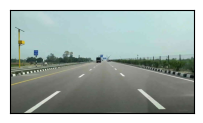

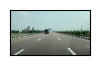

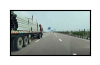

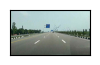

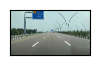

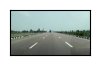

In [4]:
listing_of_image(test_images)

In [5]:
def RGB_coloring(image):
    
    #foor white
    lower_threshold = np.uint8([200, 200, 200])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    #for yellow
    lower_threshold = np.uint8([175, 175,   0])
    upper_threshold = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower_threshold, upper_threshold)
    
    #Combination of white nd yellow 
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

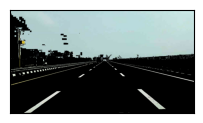

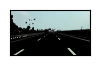

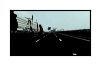

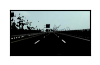

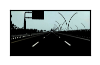

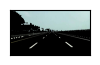

In [6]:
listing_of_image(list(map(RGB_coloring, test_images)))

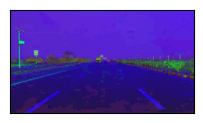

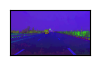

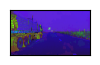

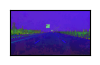

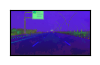

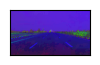

In [7]:
def converting_to_hsv(image):
    """
    Convert RGB images to HSV.
        
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

listing_of_image(list(map(converting_to_hsv, test_images)))

In [8]:
def HSV_color_selecting(image):
    """
    Apply color selection to the HSV images to blackout everything except for white and yellow lane lines.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    #Convert the input image to HSV 
    converted_image = converting_to_hsv(image)
    
    #White dotted on road
    lower_threshold = np.uint8([0, 0, 210])
    upper_threshold = np.uint8([255, 30, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Yellow dots on road
    lower_threshold = np.uint8([18, 80, 80])
    upper_threshold = np.uint8([30, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

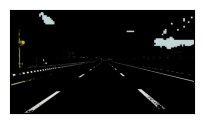

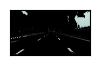

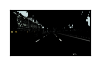

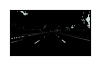

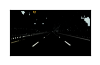

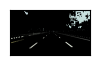

In [9]:
listing_of_image(list(map(HSV_color_selecting, test_images)))

In [10]:
def convert_hsl(image):
   
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

#listing_of_image(list(map(convert_hsl, test_images)))

In [11]:
def HSL_color_selecting(image):
    """
    Apply color selection to the HSL images to blackout everything except for white and yellow lane lines.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    #Convert the input image to HSL
    converted_image = convert_hsl(image)
    
    #White color mask
    lower_threshold = np.uint8([0, 200 , 0])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Yellow color mask
    lower_threshold = np.uint8([10, 0, 100])
    upper_threshold = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)
    
    #Combine white and yellow masks
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)
    
    return masked_image

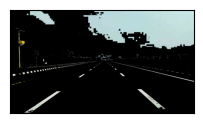

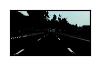

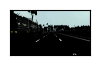

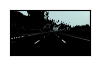

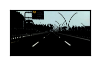

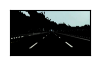

In [12]:
listing_of_image(list(map(HSL_color_selecting, test_images)))

In [13]:
color_selected_images = list(map(HSL_color_selecting, test_images))

In [14]:
def gray_scaling_of_image(image):
    
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

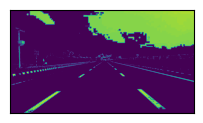

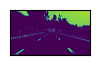

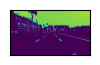

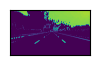

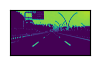

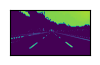

In [15]:
gray_images = list(map(gray_scaling_of_image, color_selected_images))
listing_of_image(gray_images)

In [16]:
def gaussian(image, kernel_size = 11):
   
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

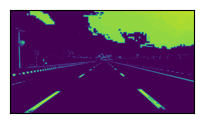

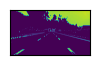

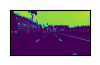

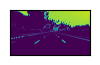

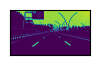

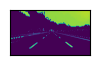

In [17]:
blur_images = list(map(gaussian, gray_images))
listing_of_image(blur_images)

In [18]:
def canny_edge_detection(image, low_threshold = 50, high_threshold = 150):
    
    return cv2.Canny(image, low_threshold, high_threshold)

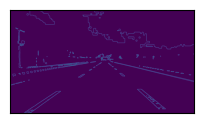

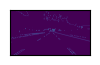

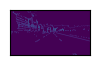

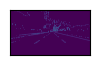

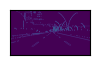

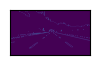

In [19]:
edge_detected_images_are = list(map(canny_edge_detection, blur_images))

listing_of_image(edge_detected_images_are)

In [20]:
def region_of_selections(image):
    
    mask = np.zeros_like(image)   
    
    #Defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    
    color=(255,0,0)
    
    #We could have used fixed numbers as the vertices of the polygon,
    #but they will not be applicable to images with different dimesnions.
    
    rows, cols = image.shape[:2]
    bottom_left  = [cols * 0.1, rows * 0.95]
    top_left     = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right    = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

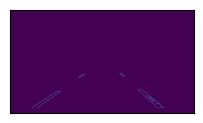

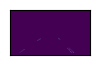

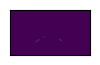

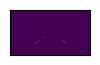

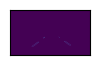

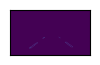

In [21]:
masked_images = list(map(region_of_selections, edge_detected_images_are))
listing_of_image(masked_images)

In [22]:
def hough_transformation(image):
    
    rho = 1              #Distance resolution of the accumulator i
    theta = np.pi/180    #Angle resolution 
    threshold = 20  
    minLineLength = 20   #line segment
    maxLineGap = 300     #Maximum allowed gap 
    return cv2.HoughLinesP(image, rho = rho, theta = theta, threshold = threshold,
                           minLineLength = minLineLength, maxLineGap = maxLineGap)

In [23]:
hough_lines = list(map(hough_transformation, masked_images))

In [24]:
def draw_lane_line(image, lines, color = [255, 255, 0], thickness = 5):
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

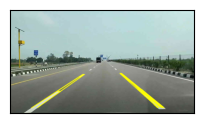

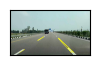

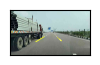

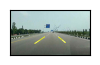

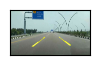

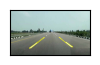

In [25]:
line_images = []
for image, lines in zip(test_images, hough_lines):
    line_images.append(draw_lane_line(image, lines))
    
listing_of_image(line_images)

In [26]:
video_stream = cv2.VideoCapture('neww4.mp4')

# Randomly select 20 frames
frameIds = video_stream.get(cv2.CAP_PROP_FRAME_COUNT) * np.random.uniform(size=20)

# Store selected "frames" in an array
frames = []
for fid in frameIds:
    video_stream.set(cv2.CAP_PROP_POS_FRAMES, fid)
    ret, frame = video_stream.read()
    frames.append(frame)
    
video_stream.release()

In [27]:
def average_slope_intercept(lines):
   
    left_lines    = [] 
    left_weights  = []
    right_lines   = [] #(slope, intercept)
    right_weights = [] #(length,)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope * x1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
            
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append((length))
                
            elif slope > 0:
                right_lines.append((slope, intercept))
                right_weights.append((length))
                
                
                
    left_lane  = np.dot(left_weights,  left_lines) / np.sum(left_weights)  if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
    return left_lane, right_lane

In [28]:
def pixel_points(y1, y2, line):
    
    slope, intercept = line
    x1 = int((y1 - intercept)/slope)

    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    return ((x1, y1), (x2, y2))

In [29]:
def lane_lines(image, lines):
    """
    Create full lenghth lines from pixel points.
            image: The input test image.
            lines: input--> Hough Transform.
    """
    left_lane, right_lane = average_slope_intercept(lines)
    y1 = image.shape[0]
    y2 = y1 * 0.6
    left_line  = pixel_points(y1, y2, left_lane)
    right_line = pixel_points(y1, y2, right_lane)
    return left_line, right_line


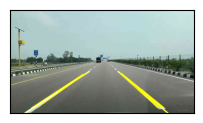

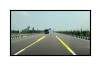

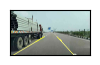

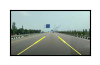

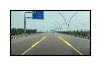

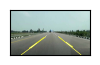

In [30]:
  
def draw_lane_lines(image, lines, color=[255,255,0], thickness=14):
  

    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)
             
    
lane_images = []
for image, lines in zip(test_images, hough_lines):
    lane_images.append(draw_lane_lines(image, lane_lines(image, lines)))

    
listing_of_image(lane_images)

In [31]:
cap = cv2.VideoCapture('neww4.mp4')  
car_classifier = cv2.CascadeClassifier('haarcascade_car.xml')

In [32]:
def detect_cars(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cars = car_classifier.detectMultiScale(gray, 1.4, 2)
    for (x, y, w, h) in cars:
        cv2.rectangle(image, (x, y), (x+w,y+h), color=(0, 255, 255), thickness=3)
    return image

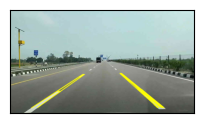

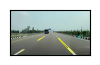

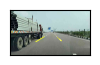

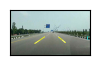

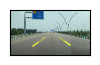

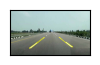

In [33]:
listing_of_image(list(map( detect_cars , test_images )))

In [34]:
#combining all algo here

In [35]:
#root map of all the algo combining here to give the common output 


def frame_processor(image):
    
    color_select = HSL_color_selecting(image)
    gray         = gray_scaling_of_image(color_select)
    smooth       = gaussian(gray)
    edges        = canny_edge_detection(smooth)
    region       = region_of_selections(edges)
    hough        = hough_transformation(region)
    boxes        = detect_cars(image)
    result       = draw_lane_lines(image, lane_lines(image, hough))
    
    
    return result 

In [36]:
def process_video(Testing_of_videos, Output_videos):
   
    input_video = VideoFileClip(os.path.join('Testing_of_videos', Testing_of_videos), audio=False)
    processed = input_video.fl_image(frame_processor)
    processed.write_videofile(os.path.join('Output_videos', Output_videos), audio=False)

In [37]:
%time process_video('neww4.mp4', 'foggy_output.mp4')
("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
nlk
""".format("output_videos\amanvideos.mp4"))

Moviepy - Building video Output_videos\foggy_output.mp4.
Moviepy - Writing video Output_videos\foggy_output.mp4



Moviepy - Done !
Moviepy - video ready Output_videos\foggy_output.mp4
CPU times: total: 6min 11s
Wall time: 2min 47s


'\n<video width="960" height="540" controls>\n  <source src="output_videos\x07manvideos.mp4">\n</video>\nnlk\n'